<a href="https://colab.research.google.com/github/MarcoMosconi/Bank-Customer-Churn/blob/main/517462_Mosconi_MLProject_19022024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import itertools

#preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

#classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer

#imbalanced classes
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import loguniform, uniform

from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve

from sklearn.inspection import permutation_importance

# Dataset:
https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
This dataset is about bank customer churn, taking information, like age, gender, tenure and balance about bank customers from France, Germany and Spain.
The scope of this project is a binary classification, predicting whether these customers exited the bank or not.

In [ ]:
data = pd.read_csv("/work/20231220-104031/Customer-Churn-Records.csv")
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [ ]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

Drop the features:
- **RowNumber**
- **CustomerId**
- **Surname**

In [ ]:
data.drop(columns=['RowNumber'], inplace=True)
data.drop(columns=['CustomerId'], inplace=True)
data.drop(columns=['Surname'], inplace=True)

# Introducing Missing Data

Since the dataset is clean, I add some noise simulating real-world data.

In [ ]:
def add_missing(col, amount, seed):
    np.random.seed(seed)
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [ ]:
data['Age']= add_missing(data['Age'], 0.08, 1)
data['Satisfaction Score'] = add_missing(data['Satisfaction Score'], 0.1, 30)
data['Tenure'] = add_missing(data['Tenure'], 0.05, 42)
data['Gender'] = add_missing(data['Gender'], 0.06, 5)
data['Geography'] = add_missing(data['Geography'], 0.09, 78)

<AxesSubplot: >

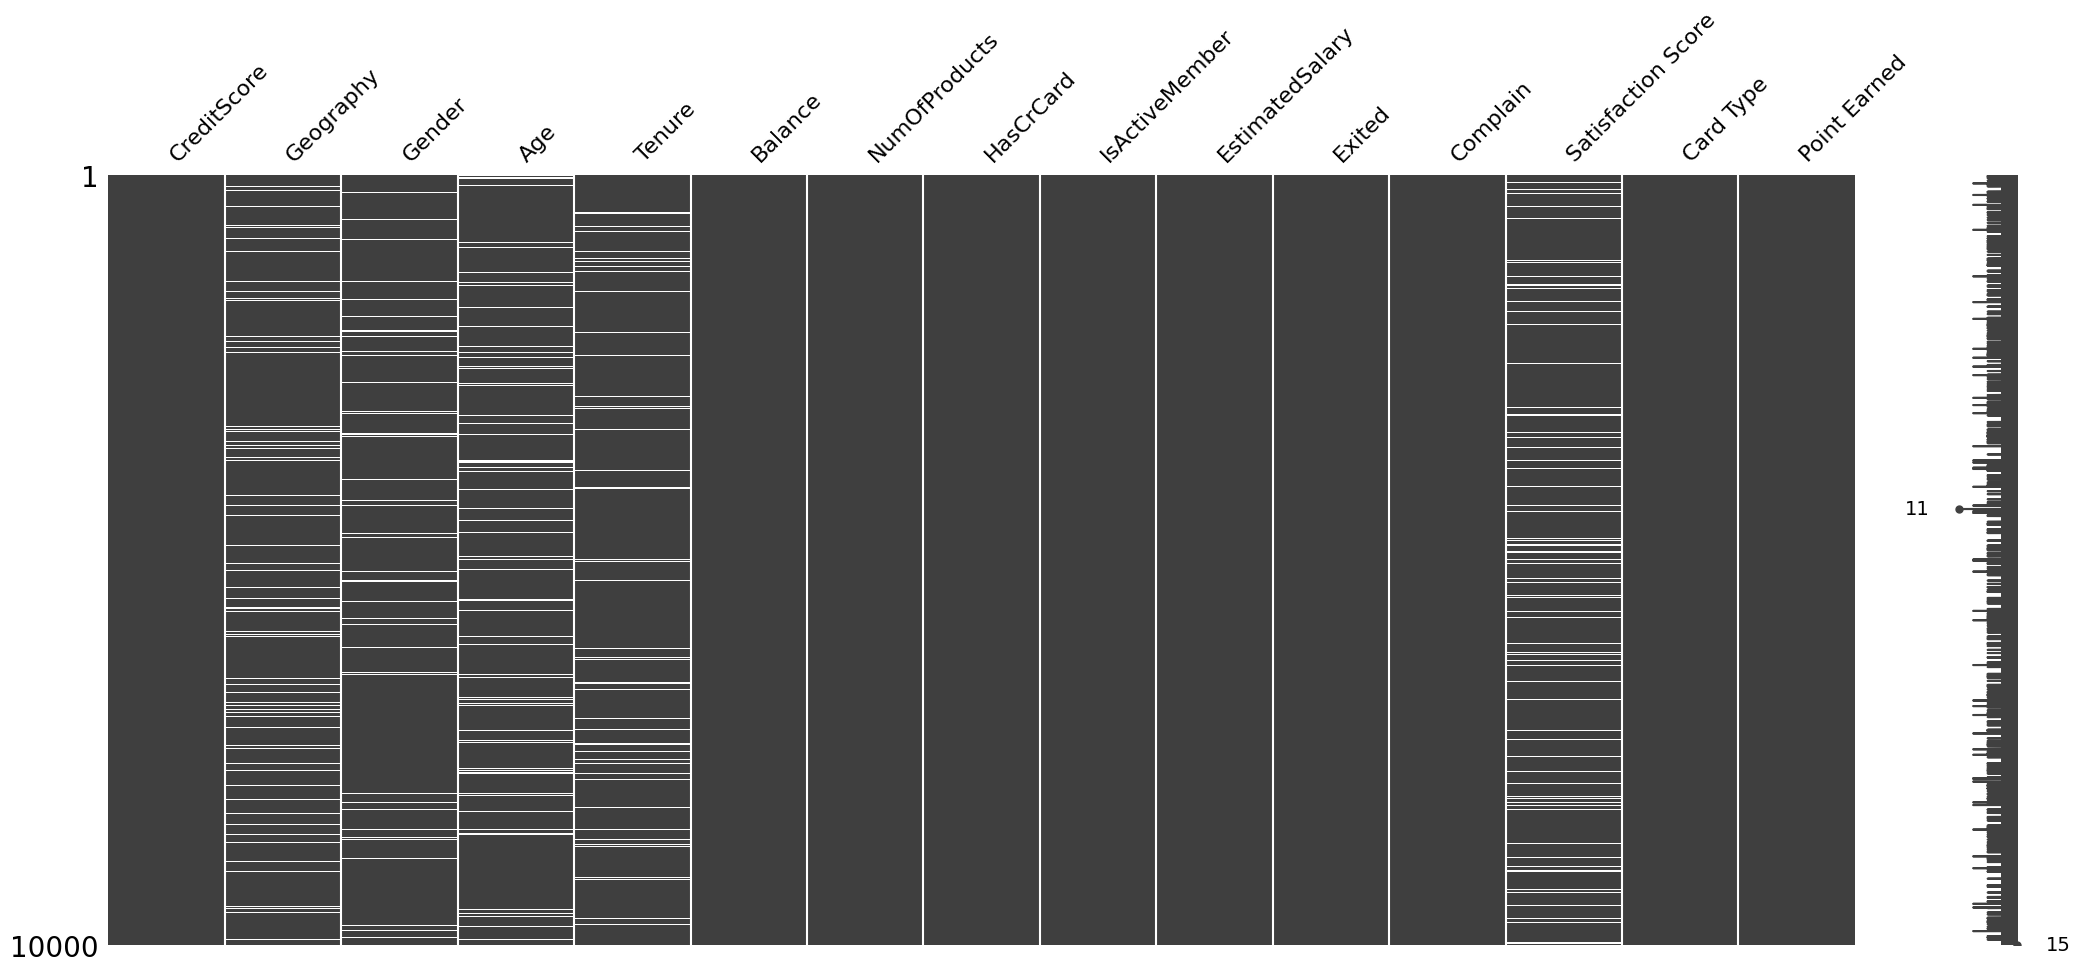

In [ ]:
msno.matrix(data)

# Data Analysis

Build a correation matrix and plot the features looking at their distribution with respect to the target feature, Exited.


<AxesSubplot: >

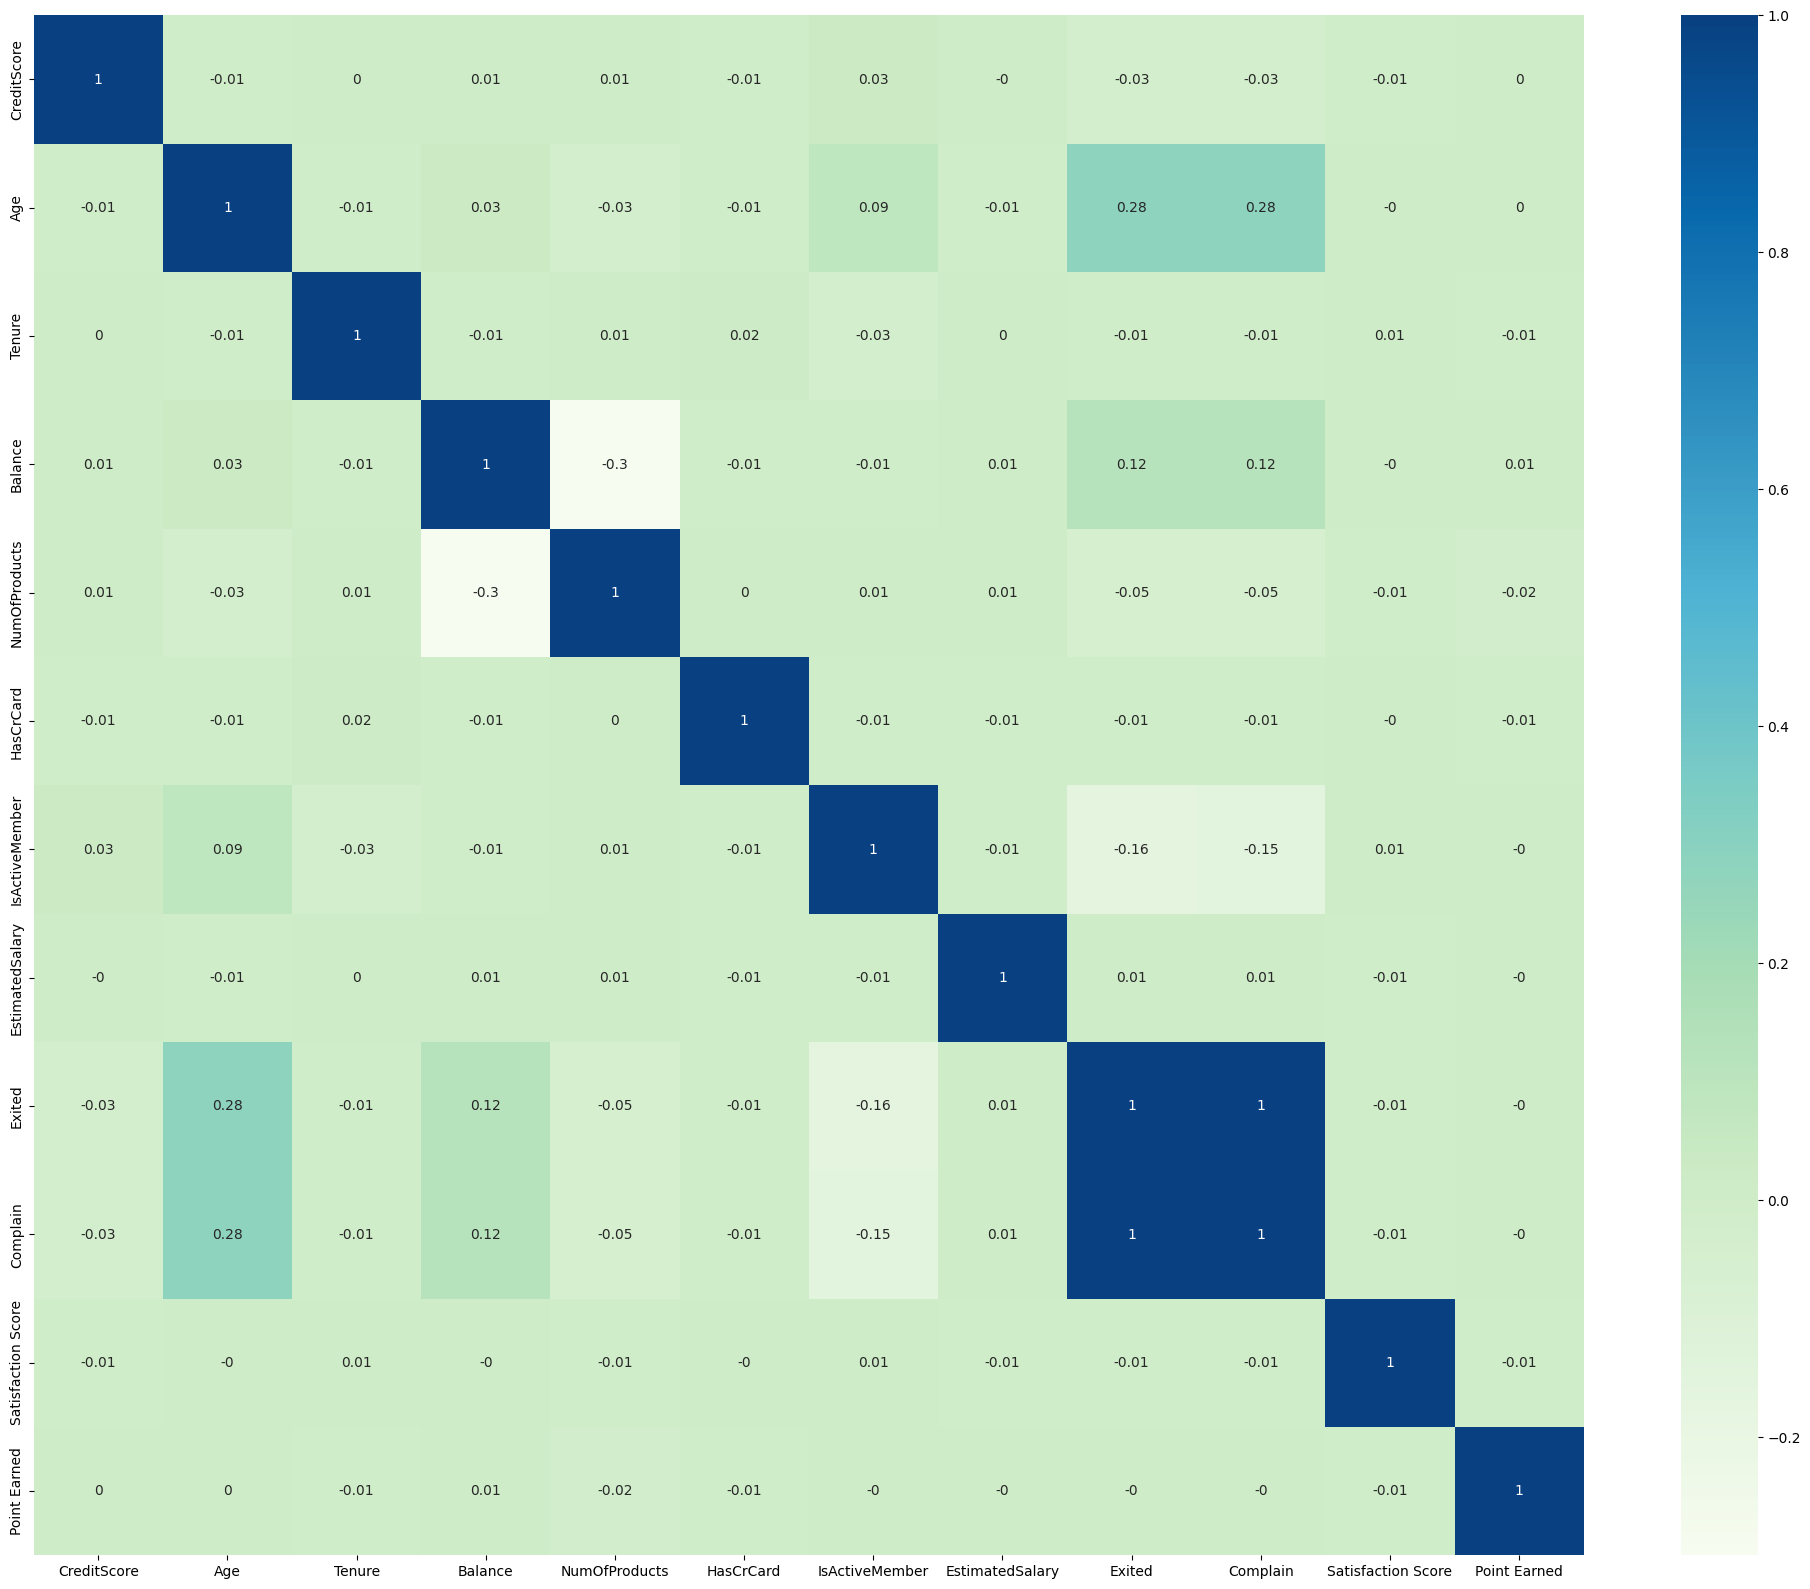

In [ ]:
corr = data.corr().round(2)
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'GnBu')

It is necessary to drop the Complain feature since it has a 1 correlation with the target feature. Trying to run a pipeline with XGBClassifier I obtained an f1 of 0.99 on the test, it's like having the target feature inside the train set

In [ ]:
data.drop(columns=['Complain'], inplace=True)

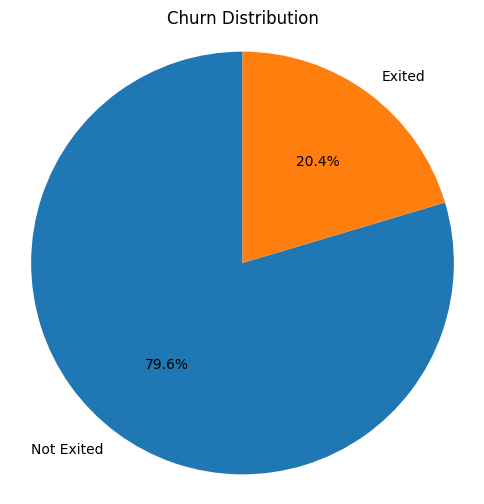

In [ ]:
plt.figure(figsize=(6, 6))
churn_counts = data['Exited'].value_counts()
plt.pie(churn_counts, labels=['Not Exited', 'Exited'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Distribution')
plt.show()

The target feature is highly imbalanced

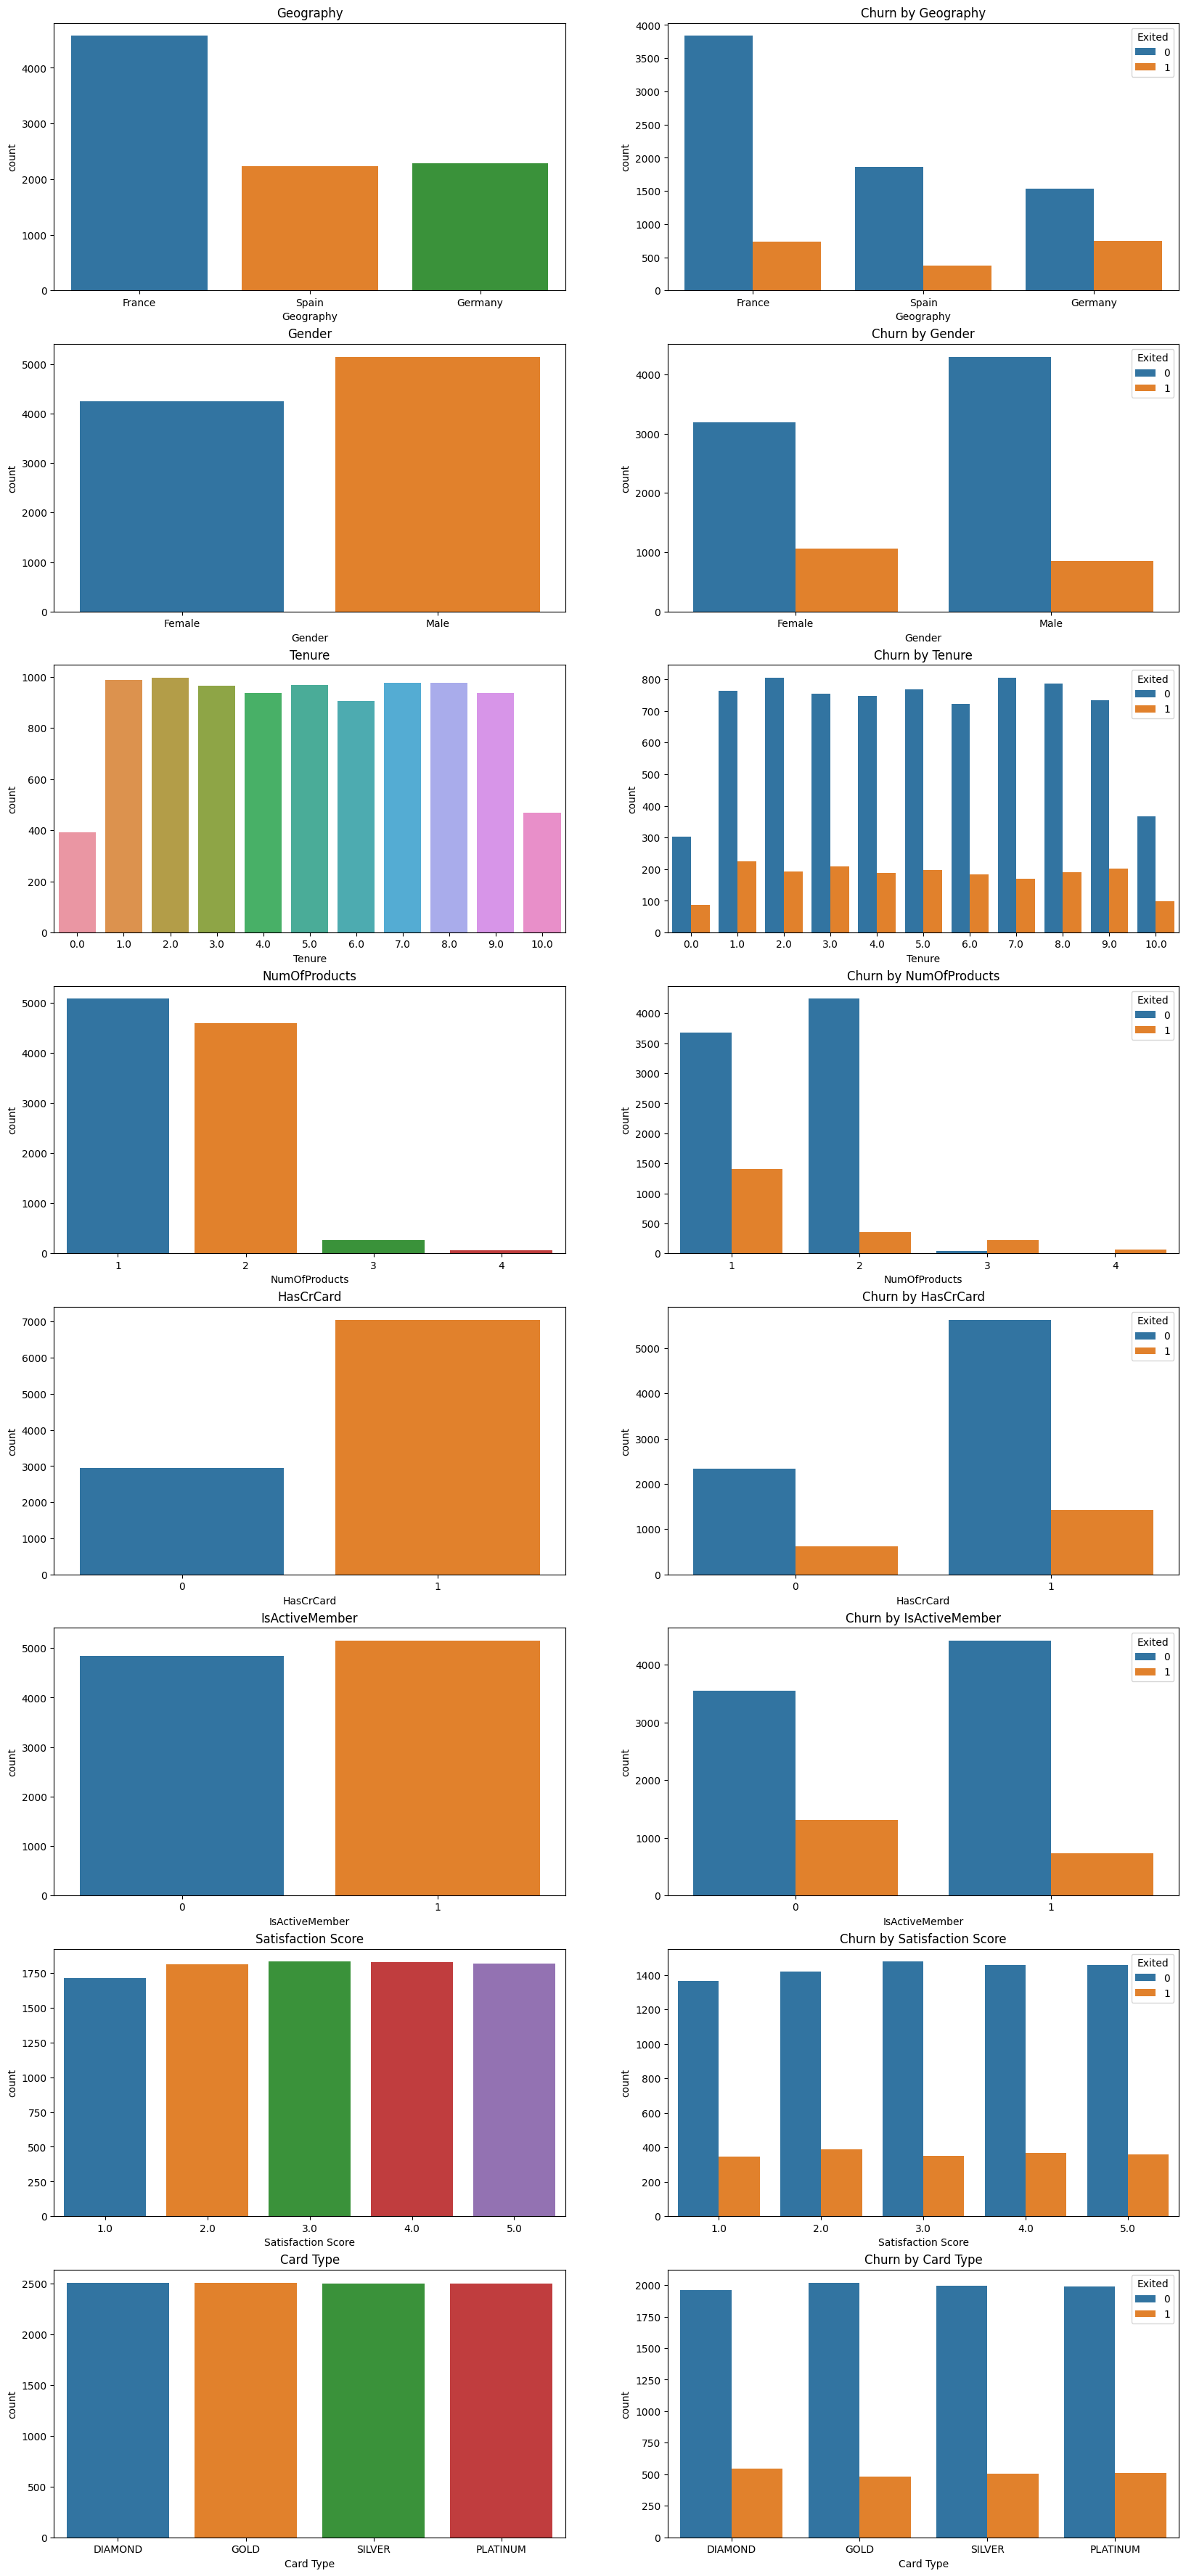

In [ ]:
plt.figure(figsize=(20,45))

features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Satisfaction Score',	'Card Type']
for i, feature in enumerate(features):
  plt.subplot(8,2,i*2+1)
  plt.title(feature)
  sns.countplot(x=feature, data=data)

  plt.subplot(8,2,i*2+2)
  plt.title(f'Churn by {feature}')
  sns.countplot(x=feature, hue='Exited', data=data)

Most of the discrete and categorical variables are well distributed. The customers are mainly from France but the german ones are the most prone to exiting. We can also see that almost everybody has purchased 1 or 2 products and in the non-active members there is a much higher percentage of customers who left with respect to the active ones.

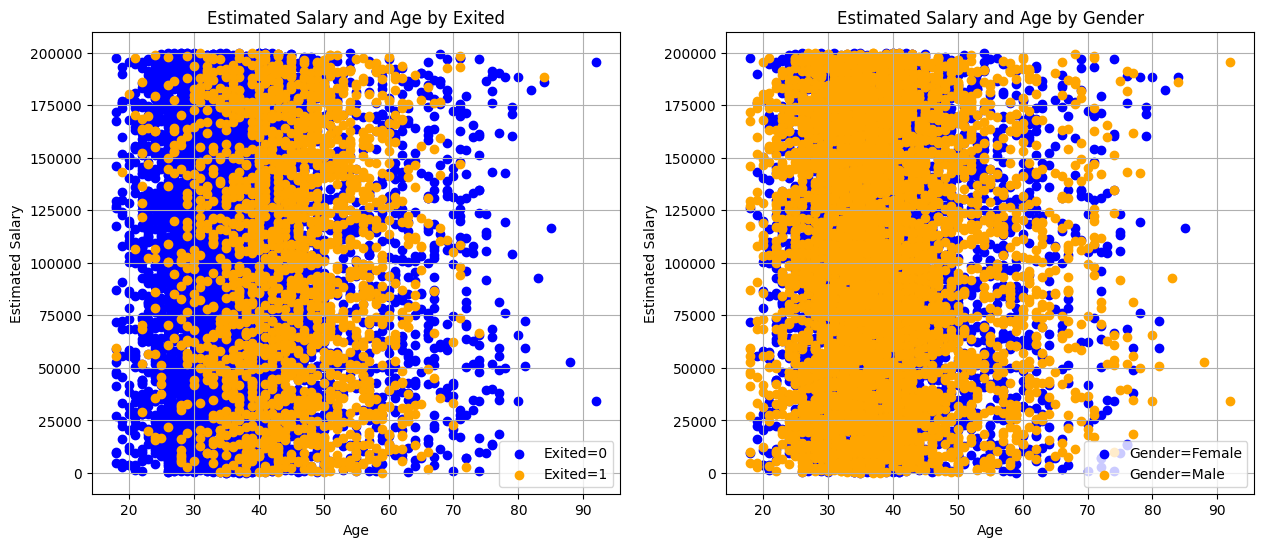

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

exited_values = [0, 1]
colors = ['blue', 'orange']

for ax, category in zip(axes, ['Exited', 'Gender']):
    for value, color in zip(exited_values if category == 'Exited' else ['Female', 'Male'], colors):
        subset = data[data[category] == value]
        ax.scatter(subset['Age'], subset['EstimatedSalary'], c=color, label=f'{category}={value}')

    ax.set_title(f'Estimated Salary and Age by {category}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Estimated Salary')
    ax.legend()
    ax.grid(True)

plt.show()

We can see that the Estimated Salary is uniformly distributed while Age is more bell-shaped, with the mean around 40.

I also checked the relation between Estimated Salary and Gender, since, if the dataset mirrored reality, there would have been higher salaries for males, but it is equally distributed.

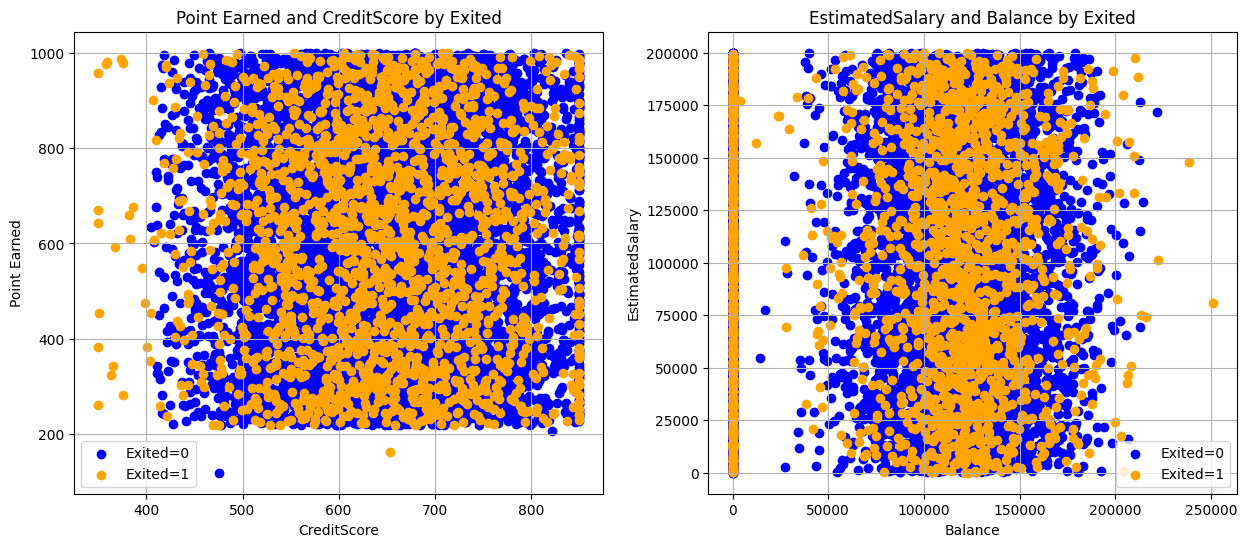

In [ ]:
exited_values = [0, 1]
colors = ['blue', 'orange']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for ax, x_feature, y_feature in zip(axs, ['CreditScore', 'Balance'], ['Point Earned', 'EstimatedSalary']):
    for exited, color in zip(exited_values, colors):
        subset = data[data['Exited'] == exited]
        ax.scatter(subset[x_feature], subset[y_feature], c=color, label=f'Exited={exited}')

    ax.set_title(f'{y_feature} and {x_feature} by Exited')
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend()
    ax.grid(True)

plt.show()

The feature Credit Score is bell-shaped with the mean between 600 and 700, while the feature Credit Score is uniformly distributed starting from 200.

In [ ]:
zero_balance= (data['Balance'] == 0).sum()
exited_zero_b = ((data['Balance'] == 0) & (data['Exited'] == 1)).sum()
print(f'Balance has {zero_balance} 0 values, {exited_zero_b} exited and {zero_balance-exited_zero_b} didn\'t')

lower_bound = 75000
upper_bound = 150000

range_balance = ((data['Balance'] >= lower_bound) & (data['Balance'] <= upper_bound)).sum()
print(f'Balance has {range_balance} values between {lower_bound} and {upper_bound}')

Balance has 3617 0 values, 500 exited and 3117 didn't
Balance has 4990 values between 75000 and 150000


The feature Balance has more than 1/3 of the instances belonging to the value 0, while the rest is mostly between 75k and 150k, hence I decided to make it a binary feature with 0 if the balance is 0 and 1 otherwise, creating a customer transfomer.

# Creating Customer Transformer

In [ ]:
class BalanceTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X['Balance'] = (X['Balance'] != 0).astype(int)
    return X

  def get_feature_names_out(self, input_features=None):
    return input_features

The transform method takes the instances and converts them in 1 if they are different than 0.
The get_feaure_names_out is useful since later I'll plot the transformed train set, and the BalanceTransformer does not provide this method itself

# Defining Column Transformer

I used:

- **Standard Scaler**: for bell-shaped features (Age, CreditScore, NumOfProducts)
- **MinMaxScaler**: for uniform distributions (Satisfaction Score, Tenure, EstimatedSalary, Point Earned)
- **OneHotEncoder**: for the categorical nominal features (Gender, Geography, Card Type)
- **KNNImputer**: for the numerical features with missing values (Age, Satisfaction Score, Tenure)
- **SimpleImputer**: for the categorical features with missing values (Gender, Geography)

In [ ]:
pipeline_age = Pipeline([
    ('imp', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

pipeline_satisfaction_tenure= Pipeline([
    ('imp', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

pipeline_gender_geography = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(categories='auto', drop='first',handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('age', pipeline_age, ['Age']),
    ('satisfaction_tenure', pipeline_satisfaction_tenure, ['Satisfaction Score', 'Tenure']),
    ('gender_geography', pipeline_gender_geography, ['Gender', 'Geography']),
    ('credit_product', StandardScaler(), ['CreditScore', 'NumOfProducts']),
    ('salary_point', MinMaxScaler(), ['EstimatedSalary', 'Point Earned']),
    ('card', OneHotEncoder(categories='auto', drop='first',handle_unknown='ignore'), ['Card Type']),
    ('balance', BalanceTransformer(), ['Balance'])
],
remainder='passthrough',
verbose_feature_names_out=False,
sparse_threshold=0)

The ramainder='passthrough' is necessary to maintain the HasCrCard and the IsActiveMember features, which are already binary

# Training and Test sets

In [ ]:
X = data.drop(columns=['Exited'])
y = data['Exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42, shuffle=True)

In [ ]:
final_transformation.fit(X_train)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('age',
                                 Pipeline(steps=[('imp', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age']),
                                ('satisfaction_tenure',
                                 Pipeline(steps=[('imp', KNNImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Satisfaction Score', 'Tenure']),
                                ('gender_geography',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Gender', 'Geography']),
                                ('credit_product', StandardScaler(),
                                 ['CreditScore', 'NumOfProducts']),
                                ('salary_point', MinMaxScaler(),
                                 ['EstimatedSalary', 'Point Earned']),
                                ('card',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Card Type']),
                                ('balance', BalanceTransformer(), ['Balance'])],
                  verbose_feature_names_out=False)

In [ ]:
feature_names = final_transformation.get_feature_names_out()
feature_names

array(['Age', 'Satisfaction Score', 'Tenure', 'Gender_Male',
       'Geography_Germany', 'Geography_Spain', 'CreditScore',
       'NumOfProducts', 'EstimatedSalary', 'Point Earned',
       'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER',
       'Balance', 'HasCrCard', 'IsActiveMember'], dtype=object)

In [ ]:
X_train_transformed_df = pd.DataFrame(final_transformation.transform(X_train), columns=feature_names)
X_train_transformed_df

,Age,Satisfaction Score,Tenure,Gender_Male,Geography_Germany,Geography_Spain,CreditScore,NumOfProducts,EstimatedSalary,Point Earned,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance,HasCrCard,IsActiveMember
0,-1.376612,0.75,0.70,1.0,0.0,1.0,1.626411,0.804113,0.115855,0.304200,1.0,0.0,0.0,0.0,0.0,1.0
1,1.681519,0.25,0.70,1.0,0.0,0.0,-0.928773,0.804113,0.665841,0.292849,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.587417,0.50,0.40,0.0,0.0,0.0,0.467785,0.804113,0.366835,0.259932,0.0,1.0,0.0,0.0,1.0,1.0
3,-1.672560,0.25,0.50,0.0,0.0,1.0,-0.142563,-0.910414,0.614329,0.353008,0.0,0.0,1.0,1.0,1.0,0.0
4,0.004479,0.00,0.60,1.0,0.0,0.0,0.405716,0.804113,0.802683,0.451759,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.201778,0.25,0.62,1.0,0.0,0.0,-0.763255,-0.910414,0.838128,0.483541,0.0,0.0,0.0,0.0,1.0,1.0
6996,0.004479,0.50,0.30,0.0,0.0,0.0,-0.152908,-0.910414,0.923489,0.261067,1.0,0.0,0.0,1.0,1.0,0.0
6997,-0.390118,0.75,0.30,1.0,0.0,0.0,-1.270154,-0.910414,0.996641,0.979569,0.0,1.0,0.0,1.0,1.0,0.0
6998,-1.277963,0.50,0.90,1.0,0.0,0.0,-0.297736,0.804113,0.766203,0.255392,0.0,1.0,0.0,0.0,1.0,1.0


Standard Scaler:
- Age: ~ (-2, 5)
- Credit Score: ~ (-3, 2)
- NumOfProducts: ~ (-0.9, 4)

# Model Selection

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', DecisionTreeClassifier())
])

In [ ]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('satisfaction_tenure',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Satisfaction Score',
                                                   'Tenure']),
                                                 ('gender_geography',
                                                  Pipeline(steps=[('imp',
                                                                   Simp...
                                                  ['CreditScore',
                                                   'NumOfProducts']),
                                                 ('salary_point',
                                                  MinMaxScaler(),
                                                  ['EstimatedSalary',
                                                   'Point Earned']),
                                                 ('card',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Card Type']),
                                                 ('balance',
                                                  BalanceTransformer(),
                                                  ['Balance'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
model_pipeline.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

The idea is to run several RandomizedSearchCVs restricting at each step the range of classifiers and techniques for sampling and dimensionality reduction.
For the first RandomizedSearchCV I put:
- Samplers: Smote, RandomOverSampler, RandomUnderSampler
- Dimensionality Reduction: PCA, LDA. I don't consider SFS since it computationally expensive
- Classifiers: Logistic Regression, Kneighbors, Decision Tree, Random Forest, SVC, XGBoost

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 0.9, 0.7, 0.5]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 0.9, 0.7, 0.5]
    },
    {
        'sampler':[RandomUnderSampler()],
        'sampler__sampling_strategy':['majority', 0.9, 0.7, 0.5]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.85, 0.9, 0.95]
    },
    {
        'dim_reduction': [LDA()]
    }
]

classifier_configs = [
    {
        'classifier': [LogisticRegression()],
        'classifier__solver' : ['saga','liblinear'],
        'classifier__C' : loguniform(0.01,100),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight' : [None, 'balanced'],

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [7,9,11,13]
    },
    {
        'classifier' : [DecisionTreeClassifier()],
        'classifier__max_depth' : [3,5,7,9],
        'classifier__criterion' : ['gini', 'entropy']
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [50, 80, 100],
        'classifier__max_depth' : [1,3,5,7]
    },
    {
        'classifier' : [SVC()],
        'classifier__C' : loguniform(0.1, 50),
        'classifier__kernel' : ['linear', 'poly', 'rbf']
    },
    {
        'classifier' : [XGBClassifier()],
        'classifier__n_estimators' : [30,50,70,100],
        'classifier__max_depth' : [3,5,7],
        'classifier__learning_rate' : loguniform(0.01, 1),
        'classifier__gamma' : [0.1, 0.2]
    }

]

In [ ]:
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 72'

In [ ]:
all_configs[2]

{'sampler': [None],
 'dim_reduction': [None],
 'classifier': [DecisionTreeClassifier()],
 'classifier__max_depth': [3, 5, 7, 9],
 'classifier__criterion': ['gini', 'entropy']}

In [ ]:
scorer = make_scorer(f1_score, average='weighted')
scores = cross_validate(RandomizedSearchCV(
            model_pipeline,
            param_distributions=all_configs,
            scoring=scorer,
            cv=4,
            n_iter=len(all_configs),
            n_jobs=-1),
        X_train,
        y_train,
        scoring=scorer,
        cv=5,
        return_estimator=True,
        verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.829 total time= 4.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min remaining:    0.0s
[CV] END ......................................., score=0.841 total time= 4.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.4min remaining:    0.0s
[CV] END ......................................., score=0.829 total time= 4.1min
[CV] END ......................................., score=0.833 total time= 4.2min
[CV] END ......................................., score=0.822 total time= 3.9min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.5min finished


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    index += 1
    print(f'Model {index}')
    print('Sampler:', estimator.best_estimator_.get_params()['sampler'])
    print('Dim reduction:', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Classifier:', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index-1])
    print('-'*10)

Model 1
Sampler: None
Dim reduction: None
Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04819243888694874,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    index += 1
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'Model {index} has F1 on training set:{f1_train}, F1 on test set:{f1_test}')

Model 1 has F1 on training set:0.8368334245526793, F1 on test set:0.8481055265505646
Model 2 has F1 on training set:0.9252207264583034, F1 on test set:0.840894659107662
Model 3 has F1 on training set:0.8600889229953139, F1 on test set:0.8500109149729236
Model 4 has F1 on training set:0.8471425259960368, F1 on test set:0.852842724061653
Model 5 has F1 on training set:0.8411440026045132, F1 on test set:0.8487342951324971


I have RandomForestClassifier and XGBClassifier as the best classifiers.
RandomForestClassifier:
- Model 5: has underfitting, since the performance on the test set is higher than the one on the train set
XGBClassifier:
- Model 1 and Model 4: have underfitting, model 4 with the best performance on the test set
- Model 2 and Model 3: have overfitting, since the performance on train set is higher than the one on the test set.

Since these are the two best classifiers I'll do another RandomizedSearchCV with just them.
- RandomForestClassifier: I change the max_depth hyperparameter since I observed underfitting.
- XGBClassifier: I encountered both underfitting and overfitting, hence I'm not changing anything seeing if it gets better with another RandomizedSearchCV

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 0.9, 0.7, 0.5]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 0.9, 0.7, 0.5]
    },
    {
        'sampler':[RandomUnderSampler()],
        'sampler__sampling_strategy':['majority', 0.9, 0.7, 0.5]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.85, 0.9, 0.95]
    },
    {
        'dim_reduction': [LDA()]
    }
]
classifier_configs = [
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [50,80,100],
        'classifier__max_depth' : [3,5,7,9]
    },
    {
        'classifier' : [XGBClassifier()],
        'classifier__n_estimators' : [30,50,70,100],
        'classifier__max_depth' : [3,5,7],
        'classifier__learning_rate' : loguniform(0.01, 1),
        'classifier__gamma' : [0.1, 0.2]
    }

]

In [ ]:
all_configs1 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs1.append(dict(all_parameters))

In [ ]:
f'Number of all possible configurations: {len(all_configs1)}'

'Number of all possible configurations: 24'

In [ ]:
scores1 = cross_validate(RandomizedSearchCV(
            model_pipeline,
            param_distributions=all_configs1,
            scoring=scorer,
            cv=4,
            n_iter=len(all_configs1),
            n_jobs=-1),
        X_train,
        y_train,
        scoring=scorer,
        cv=5,
        return_estimator=True,
        verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.835 total time= 1.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[CV] END ......................................., score=0.843 total time= 1.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s
[CV] END ......................................., score=0.828 total time= 1.3min
[CV] END ......................................., score=0.837 total time= 1.3min
[CV] END ......................................., score=0.834 total time= 1.2min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min finished


In [ ]:
for index, estimator in enumerate(scores1['estimator']):
    index += 1
    print(f'Model {index}')
    print('Sampler:', estimator.best_estimator_.get_params()['sampler'])
    print('Dim reduction:', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Classifier:', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores1['test_score'][index-1])
    print('-'*10)

Model 1
Sampler: None
Dim reduction: None
Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04723896402655891,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 

In [ ]:
for index, estimator in enumerate(scores1['estimator']):
    index += 1
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'Model {index} has F1 on training set:{f1_train}, F1 on test set:{f1_test}')

Model 1 has F1 on training set:0.8528570054193247, F1 on test set:0.8436640152590458
Model 2 has F1 on training set:0.8396013899247246, F1 on test set:0.8447626101824957
Model 3 has F1 on training set:0.8701169118720518, F1 on test set:0.8499654423742536
Model 4 has F1 on training set:0.8442498688783571, F1 on test set:0.8499144478284972
Model 5 has F1 on training set:0.8719312725784607, F1 on test set:0.8507636983113888


We can observe than only model 3 has RandomForestClassifier, while all the others have XGBClassifier.
RandomForestClassifier:
Model 1 and in particular model 3 and model 5 have overfitting, with model 5 being the one with the best performance on test set, while model 2 and model 4 have underfitting.
Given this information I decide to consider XGBClassifier as the classifier with which I'll have the best model.
The next step is doing another RandomizedSearchCV just with XGBClassifier, and given the models I just observed I'll put:
- Sampler:
    - None
    - Smote with strategy centred around 0.5
    - RandomOverSampler with strategy centred around 0.7
- Dimensionality Reduction:
    - None
- Classifier:
    - XGBClassifier with more specific hyperparameters


In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':[0.55, 0.5, 0.45]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':[0.75, 0.7, 0.65]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    }
]
classifier_configs = [
    {
        'classifier' : [XGBClassifier()],
        'classifier__n_estimators' : [40,50,60,70,80,90,100,110],
        'classifier__max_depth' : [3,5,7],
        'classifier__learning_rate' : loguniform(0.01, 1),
        'classifier__gamma' : [0.05, 0.1, 0.15, 0.2, 0.25]
    }

]

In [ ]:
all_configs2 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs2.append(dict(all_parameters))

In [ ]:
f'Number of all possible configurations: {len(all_configs2)}'

'Number of all possible configurations: 3'

In [ ]:
scores2 = cross_validate(RandomizedSearchCV(
            model_pipeline,
            param_distributions=all_configs2,
            scoring=scorer,
            cv=4,
            n_iter=len(all_configs2)*10,
            n_jobs=-1),
        X_train,
        y_train,
        scoring=scorer,
        cv=5,
        return_estimator=True,
        verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.825 total time= 1.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[CV] END ......................................., score=0.839 total time= 1.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s
[CV] END ......................................., score=0.842 total time= 1.2min
[CV] END ......................................., score=0.833 total time= 1.2min
[CV] END ......................................., score=0.827 total time= 1.2min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.9min finished


In [ ]:
for index, estimator in enumerate(scores2['estimator']):
    index += 1
    print(f'Model {index}')
    print('Sampler:', estimator.best_estimator_.get_params()['sampler'])
    print('Dim reduction:', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Classifier:', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores2['test_score'][index-1])
    print('-'*10)

Model 1
Sampler: SMOTE(sampling_strategy=0.5)
Dim reduction: None
Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.15, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06662403507159828,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_b

In [ ]:
for index, estimator in enumerate(scores2['estimator']):
    index += 1
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'Model {index} has F1 on training set:{f1_train}, F1 on test set:{f1_test}')

Model 1 has F1 on training set:0.8449341246080387, F1 on test set:0.853462192448272
Model 2 has F1 on training set:0.8484016293246184, F1 on test set:0.85403379908804
Model 3 has F1 on training set:0.8447903155684356, F1 on test set:0.8527651888341543
Model 4 has F1 on training set:0.862924161902422, F1 on test set:0.8536900139586966
Model 5 has F1 on training set:0.8452302562917358, F1 on test set:0.8538888475556308


We can observe that the performance is better than before on test set than before but there is still underfitting on all the models apart from model 4. Now I will run another RandomizedSearchCV to fix the underfitting adding also 3 other hyperparameters (min_child_weight, subsample, colsubsample_by) and adjusting the other ones based on the models I just obtained.
- n_estimators: two models have 50, one 90, one 100, one 110, hence I start from 50 and add 120
- max_depth: in 3 models out of 4 which have underfitting it is 3, hence I put 4,5,6 as possible values
- learning_rate: the values go from 0.02 to 0.17, hence I put uniform(loc=0.02, scale=0.16)
- gamma: there is not are not recurrent values, hence I just put more specific ones

I also put Smote as the only sampler since all the 5 models have neither None nor RandomOverSampler

In [ ]:
sampler_configs = [
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':[0.575, 0.55, 0.525, 0.5, 0.475, 0.45, 0.425]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    }
]
classifier_configs = [
    {
        'classifier' : [XGBClassifier()],
        'classifier__n_estimators' : [50,60,70,90,100,110,120],
        'classifier__max_depth' : [4,5,6],
        'classifier__learning_rate' : uniform(loc=0.02, scale=0.16),
        'classifier__gamma' : [0.075, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275],
        'classifier__min_child_weight': [1,2,3,4],
        'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

]

In [ ]:
all_configs4 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs4.append(dict(all_parameters))

In [ ]:
f'Number of all possible configurations: {len(all_configs4)}'

'Number of all possible configurations: 1'

In [ ]:
scores4 = cross_validate(RandomizedSearchCV(
            model_pipeline,
            param_distributions=all_configs4,
            scoring=scorer,
            cv=4,
            n_iter=len(all_configs4)*30,
            n_jobs=-1),
        X_train,
        y_train,
        scoring=scorer,
        cv=5,
        return_estimator=True,
        verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.826 total time= 1.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[CV] END ......................................., score=0.847 total time= 1.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[CV] END ......................................., score=0.840 total time= 1.2min
[CV] END ......................................., score=0.841 total time= 1.2min
[CV] END ......................................., score=0.829 total time= 1.2min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min finished


In [ ]:
for index, estimator in enumerate(scores4['estimator']):
    index += 1
    print(f'Model {index}')
    print('Sampler:', estimator.best_estimator_.get_params()['sampler'])
    print('Dim reduction:', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Classifier:', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores4['test_score'][index-1])
    print('-'*10)

Model 1
Sampler: SMOTE(sampling_strategy=0.475)
Dim reduction: None
Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.075, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04163197819607859,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_b

In [ ]:
for index, estimator in enumerate(scores4['estimator']):
    index += 1
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'Model {index} has F1 on training set:{f1_train}, F1 on test set:{f1_test}')

Model 1 has F1 on training set:0.8530043122252586, F1 on test set:0.8498915328977441
Model 2 has F1 on training set:0.854479009026126, F1 on test set:0.8542050630142979
Model 3 has F1 on training set:0.8641815772535704, F1 on test set:0.8485150411885849
Model 4 has F1 on training set:0.8413999640740076, F1 on test set:0.8538775200413696
Model 5 has F1 on training set:0.8426833110265225, F1 on test set:0.8566489392456443


We finally have good performances both on test and training sets, with only model 3 with evident overfitting and model 4 and 5 with underfitting, while model 2 has almost equal f1 scores and model 1 has little overfitting
What I will do now is defining one last RandomizedSearchCV with an even more specific set of hyperparameters to identify the best configuration and running the fit method.

# Refinement of the selected model

In [ ]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('classifier', XGBClassifier())
])

In [ ]:
params = {
    'sampler__sampling_strategy': [0.55, 0.525, 0.5, 0.475, 0.45],
    'classifier__n_estimators': [70, 80, 90, 100, 105, 110, 115, 120, 125, 130, 140],
    'classifier__max_depth': [4,5,6],
    'classifier__learning_rate': uniform(loc=0.06, scale=0.06),
    'classifier__gamma': uniform(loc=0.1, scale=0.2),
    'classifier__min_child_weight': [1, 2, 3, 4],
    'classifier__subsample': [0.7, 0.72, 0.75, 0.78, 0.80, 0.83, 0.85, 0.88, 0.9],
    'classifier__colsample_bytree': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
}

In [ ]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring=scorer
)

In [ ]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('age',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('satisfaction_tenure',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler'...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbbcbae13a0>,
                                        'classifier__max_depth': [4, 5, 6],
                                        'classifier__min_child_weight': [1, 2,
                                                                         3, 4],
                                        'classifier__n_estimators': [70, 80, 90,
                                                                     100, 105,
                                                                     110, 115,
                                                                     120, 125,
                                                                     130, 140],
                                        'classifier__subsample': [0.8, 0.83,
                                                                  0.85, 0.88,
                                                                  0.9, 0.93,
                                                                  0.95, 0.98,
                                                                  1],
                                        'sampler__sampling_strategy': [0.525,
                                                                       0.5,
                                                                       0.475,
                                                                       0.45,
                                                                       0.425]},
                   scoring=make_scorer(f1_score, average=weighted))

In [ ]:
print('Sampler:', rs_best.best_estimator_.get_params()['sampler'])
print('Classifier:', rs_best.best_estimator_.get_params()['classifier'],rs_best.best_estimator_.get_params()['classifier'].get_params())


Sampler: SMOTE(sampling_strategy=0.425)
Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1932646910202296, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06940140174330871,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.65, '

In [ ]:
f1_train = f1_score(y_train, rs_best.best_estimator_.predict(X_train), average='weighted')
f1_test = f1_score(y_test, rs_best.best_estimator_.predict(X_test), average='weighted')
print(f1_train, f1_test)

0.8549288814983182 0.8554233045307622


We can observe that the final model has slight underfitting, but overall it is a really good model with one of the highest performances on test set ever obtained

# Learning Curve

In [ ]:
cls = rs_best.best_estimator_

In [ ]:
cls.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('satisfaction_tenure',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Satisfaction Score',
                                                   'Tenure']),
                                                 ('gender_geography',
                                                  Pipeline(steps=[('imp',
                                                                   Simp...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.06940140174330871, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=80, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = scorer,
                                                       shuffle = False)

(0.6, 1.03)

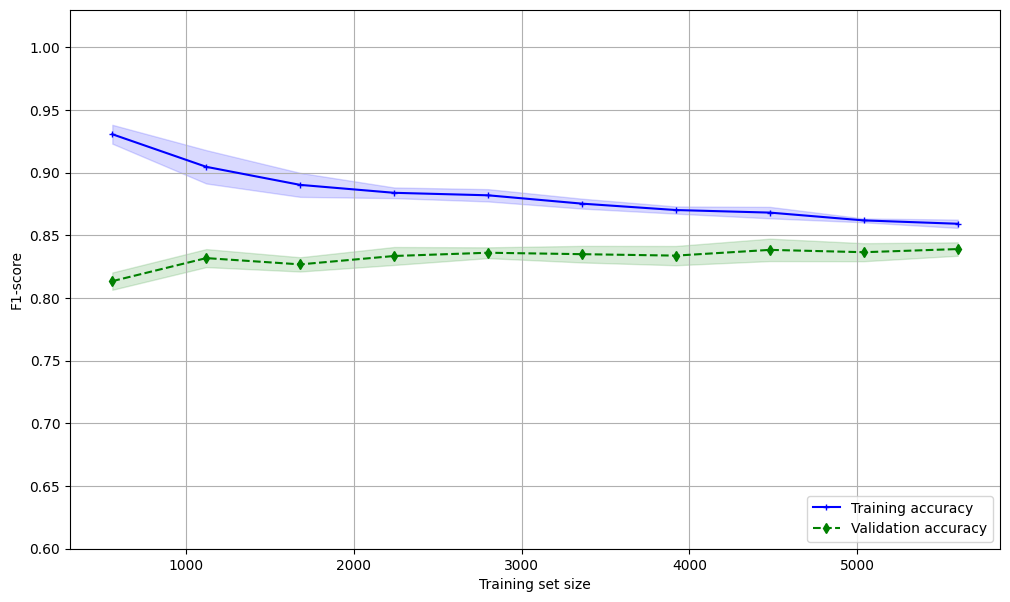

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

The learning curve shows that there is a good fitting

# ROC Curve

In [ ]:
cls.predict_proba(X_train)

array([[0.9806214 , 0.0193786 ],
       [0.3030734 , 0.6969266 ],
       [0.94087785, 0.05912215],
       ...,
       [0.8366163 , 0.16338372],
       [0.9718355 , 0.02816451],
       [0.8954111 , 0.10458891]], dtype=float32)

In [ ]:
scores = cls.predict_proba(X_train)[:,1]

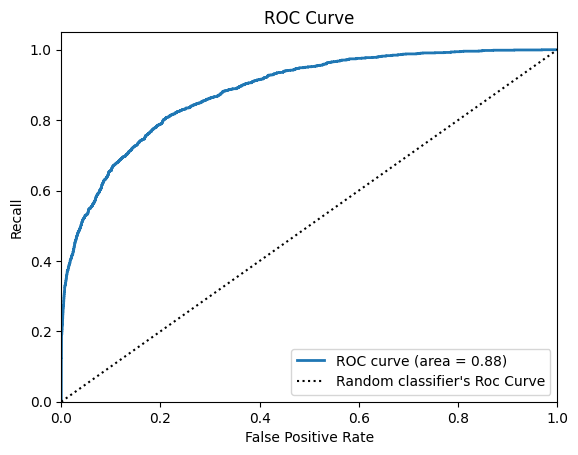

In [ ]:
fprs, recalls, thresholds = roc_curve(y_train, scores)
roc_auc = auc(fprs, recalls)

plt.figure()
plt.plot(fprs, recalls, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's Roc Curve")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC Curve shows how the model struggles a lot with Recall, True Positive Rate, when the False Positive Rate is low, hence when most of the negative instances are correctly predicted, while it's much better even with a False Positive Rate of 0.4/0.5.
However, since the score is f1 weighted, meaning that is penalizes much more the wrong predictions on the majority class (the negative), than the minority (the positive), we can imagine that we will have a high number of True Negatives, hence a low False Positive Rate, and as a consequence a weak Recall

# Confusion Matrix and best Threshold

Text(0.5, 1.0, 'Confusion Matrix on Training Set')

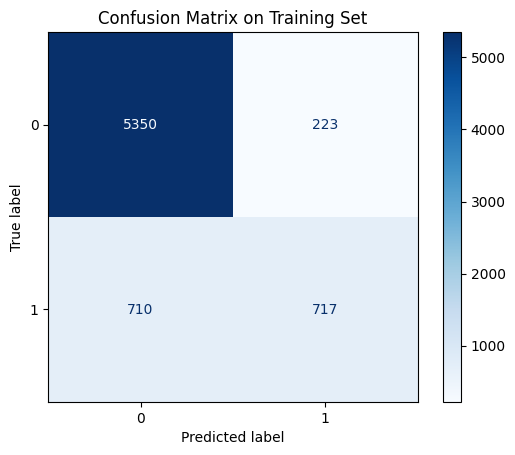

In [ ]:
predictions_train = cls.predict(X_train)
cm = confusion_matrix(y_train, predictions_train)
ConfusionMatrixDisplay.from_predictions(y_train, predictions_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Set')

Text(0.5, 1.0, 'Confusion Matrix on Test set')

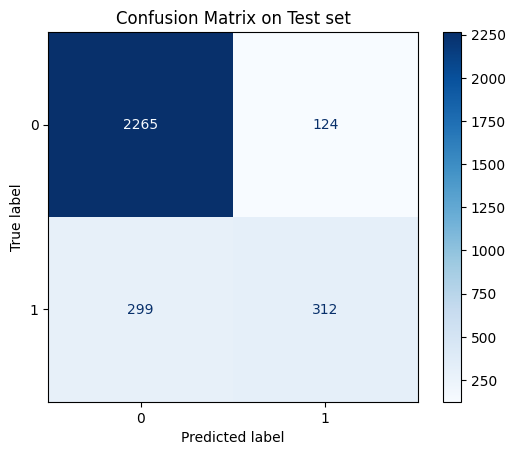

In [ ]:
predictions_test = cls.predict(X_test)
cm2 = confusion_matrix(y_test, predictions_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test set')

The confusion matrixes show that the model is very good in predicting negative values while it struggles more with the prediction of the positive ones, due to the fact that the dataset is imbalanced.
Now I will try to find the threshold maximizing the f1 of the model

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, scores)

In [ ]:
threshold = 0.5

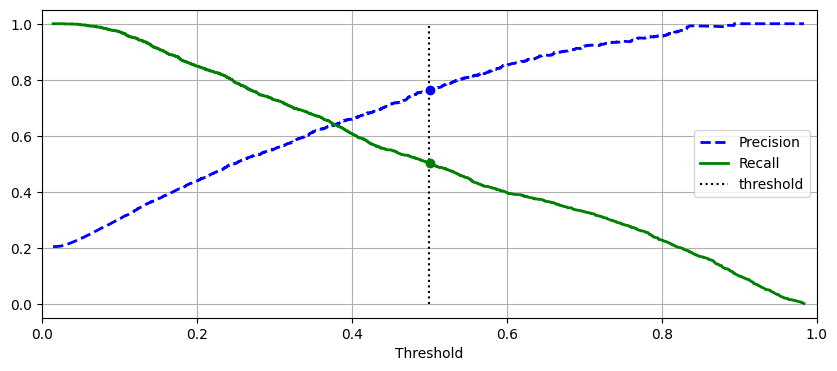

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
ax.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
ax.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
ax.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.grid()
ax.set_xlabel("Threshold")
ax.set_xlim((0,1))
plt.legend(loc="center right")
plt.show()

From the precision-recall curve we can observe that they intersect with a threshold of ~ 0.38. However, it is surely not the best one since they have low values

In [ ]:
best_f1 = 0
best_threshold = 0.5

for threshold in np.linspace(0, 1, 100):
    test_preds = (scores >= threshold).astype(int)
    f1 = f1_score(y_train, test_preds, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

In [ ]:
print(f'The best threshold is {best_threshold} with best f1 {best_f1}')

The best threshold is 0.48484848484848486 with best f1 0.8573950530667274


The threshold maximizing accuracy is at 0.48 and we can observe that the f1 is little better than the starting one, but it is not a consisent different since the default threshold is 0.5

Text(0.5, 1.0, 'Confusion Matrix on Training Set')

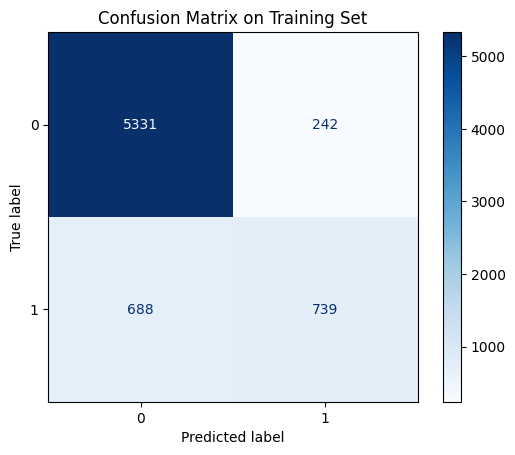

In [ ]:
predictions_train = (scores >= best_threshold).astype(int)
cm = confusion_matrix(y_train, predictions_train)
ConfusionMatrixDisplay.from_predictions(y_train, predictions_train, cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Set')

In [ ]:
scores_test = cls.predict_proba(X_test)[:,1]

Text(0.5, 1.0, 'Confusion Matrix on Test set')

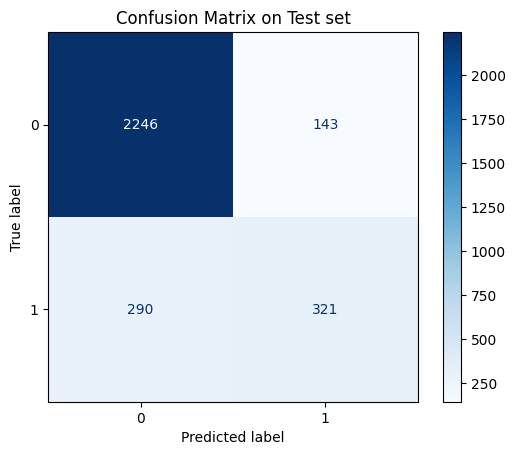

In [ ]:
predictions_test = (scores_test >= best_threshold).astype(int)
cm2 = confusion_matrix(y_test, predictions_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test set')

In [ ]:
f1_score_test = f1_score(y_test, predictions_test, average='weighted')
print(f'f1 with best threshold on test is {f1_score_test}')

f1 with best threshold on test is 0.8479523047259279


We can observe that even though the f1 on train got a little better, the one on test worsened a lot, and there is an overall situation of overfitting. By looking at the confusion matrixes we can see how by applying the new threshold the number of True Negatives decreased and the number of True Positives increased by similar quantities of instances. Being the test set much smaller than the train one, it influences a lot its performance, and since the f1 score is weighted it penalizes much more the new wrong prediction on the minority class (positive class) than the new right predictions on the majority class (negative class)

# Validation Curve

In [ ]:
print('Classifier:', rs_best.best_estimator_.get_params()['classifier'],rs_best.best_estimator_.get_params()['classifier'].get_params())

Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1932646910202296, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06940140174330871,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.65, 'device': None, 'early_stopping_rounds': 

The model has hyperparameter values:
- learning_rate: 0.07
- n_estimators: 80
- gamma: 0.19
- subsample: 0.83
- colsample_bytree: 0.65

In [ ]:
range_learning_rate = [0.001, 0.01, 0.07, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=range_learning_rate,
        param_name='classifier__learning_rate',
        cv=5,
        n_jobs=-1,
        scoring=scorer
)

(0.001, 100)

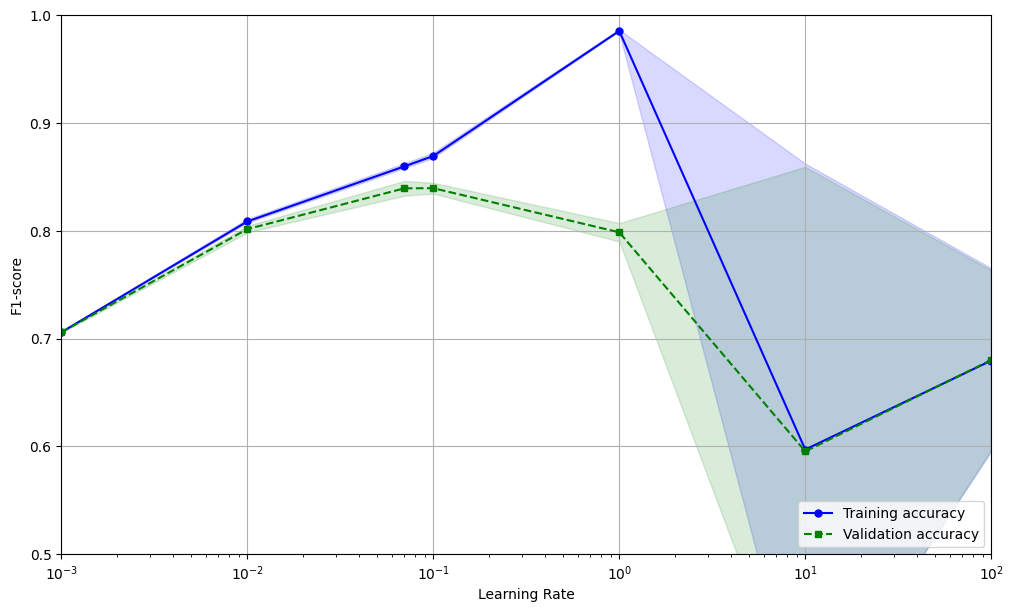

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_learning_rate, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_learning_rate,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_learning_rate, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_learning_rate,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Learning Rate')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.5, 1])
ax.set_xscale('log')
ax.set_xlim([0.001,100])

We can see that the learning rate value of 0.07 is the correct one, since for lower ones the performance on both training and validation sets decreases while for greater ones at first there is overfitting and then the performance gets much worse

In [ ]:
range_n_estimators = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=range_n_estimators,
        param_name='classifier__n_estimators',
        cv=5,
        n_jobs=-1,
        scoring=scorer
)

(10, 250)

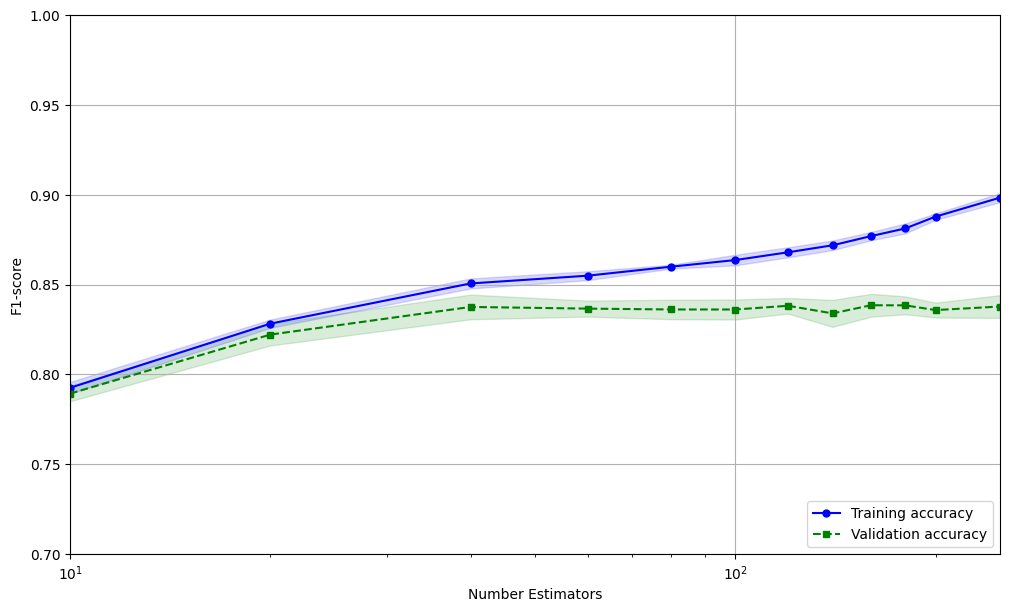

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_n_estimators, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_n_estimators,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_n_estimators, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_n_estimators,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Number Estimators')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.7, 1])
ax.set_xscale('log')
ax.set_xlim([10,250])

For the estimators maybe 80 is not the best one, since there is little overfitting, but it's not far from the optimal one, which is a little lower. For larger values the performance does not get better and the overfitting increases

In [ ]:
range_gamma = [0.001, 0.01, 0.1, 0.19, 1, 10]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=range_gamma,
        param_name='classifier__gamma',
        cv=5,
        n_jobs=-1,
        scoring=scorer
)


(0.001, 10)

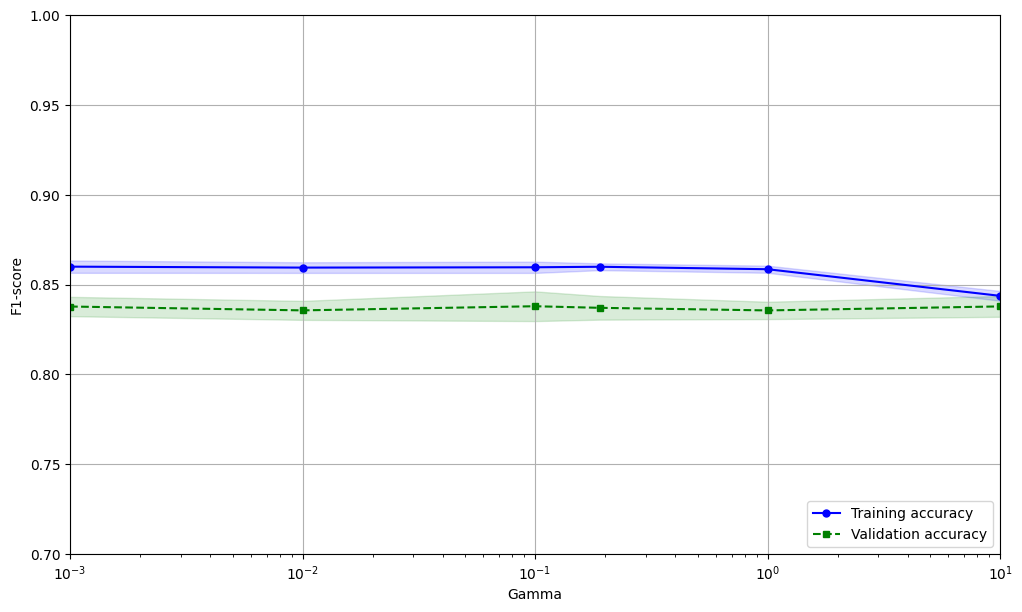

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_gamma, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_gamma,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_gamma, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_gamma,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Gamma')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.7, 1])
ax.set_xscale('log')
ax.set_xlim([0.001,10])

For gamma there is not a big difference between the values and the overfitting remains constant, just with values close to 10 it decreases

In [ ]:
range_subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.83, 0.9, 1]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=range_subsample,
        param_name='classifier__subsample',
        cv=5,
        n_jobs=-1,
        scoring=scorer
)

(0.1, 1)

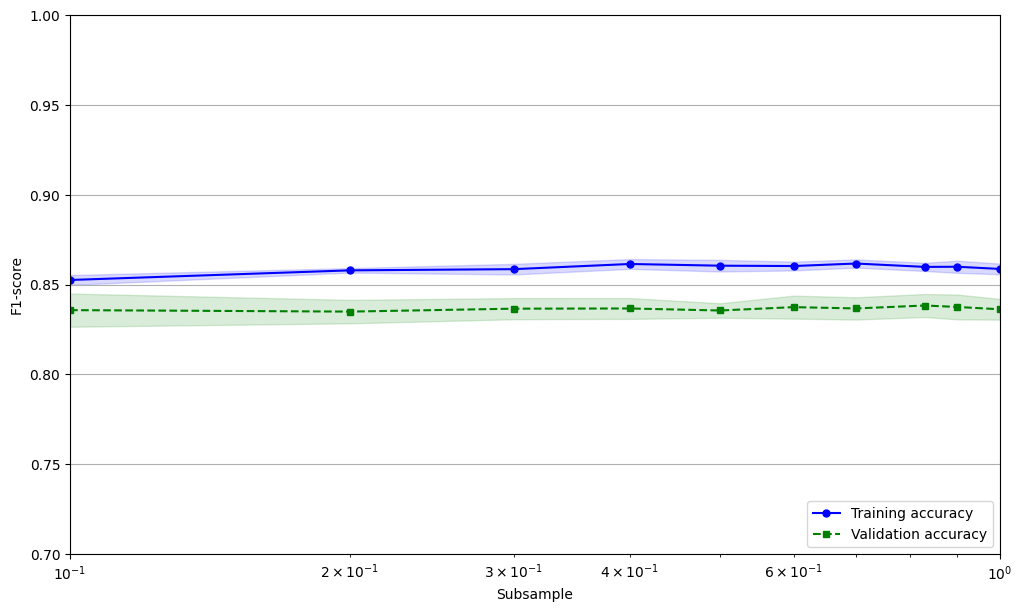

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_subsample, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_subsample,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_subsample, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_subsample,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Subsample')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.7, 1])
ax.set_xscale('log')
ax.set_xlim([0.1,1])

There is again not a relevant different between the values

In [ ]:
range_colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.7, 0.8, 0.9, 1]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=range_colsample_bytree,
        param_name='classifier__colsample_bytree',
        cv=5,
        n_jobs=-1,
        scoring=scorer
)

(0.1, 1)

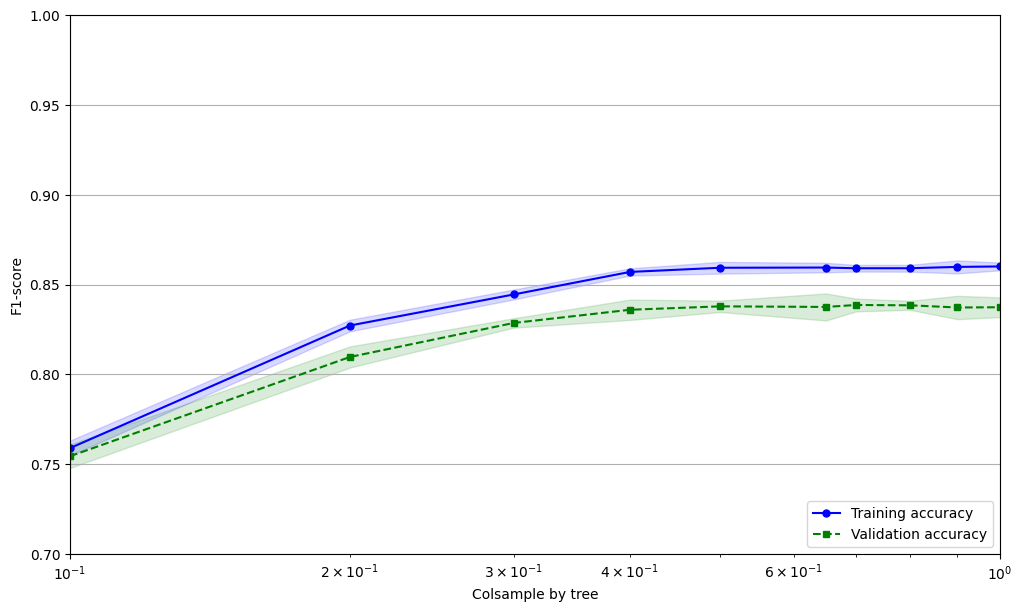

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_colsample_bytree, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_colsample_bytree,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_colsample_bytree, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_colsample_bytree,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Colsample by tree')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.7, 1])
ax.set_xscale('log')
ax.set_xlim([0.1,1])

For the values from 0.4 on the training and validation accuracy remains constant, it is not good just for 0.1 and 0.2, hence 0.65 is good colsample_bytree value

# Feature Importance

In [ ]:
r = permutation_importance(cls,
                            X_train,
                            y_train,
                            n_repeats=30,
                            random_state=0,
                            scoring=scorer)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Age     0.081 +/- 0.004
NumOfProducts0.063 +/- 0.003
IsActiveMember0.028 +/- 0.002
Geography0.013 +/- 0.002
Satisfaction Score0.007 +/- 0.001
Gender  0.006 +/- 0.001
Balance 0.006 +/- 0.001
CreditScore0.005 +/- 0.001
EstimatedSalary0.004 +/- 0.001
Point Earned0.002 +/- 0.001
Tenure  0.002 +/- 0.001
Card Type0.002 +/- 0.001
HasCrCard0.001 +/- 0.001


In [ ]:
r = permutation_importance(cls,
                            X_test,
                            y_test,
                            n_repeats=30,
                            random_state=0,
                            scoring=scorer)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Age     0.080 +/- 0.005
NumOfProducts0.062 +/- 0.004
IsActiveMember0.023 +/- 0.003


By doing the permutation feature importance we can notice how both on train and test set the most important features are Age and NumOfProducts, with also IsActiveMember contributing to the model but to a lesser extend. However, it is interesting to see how on train set there are also many other features not present in test set, but still they should not be influencing the model's performance in an evident way since their importance is very low, while if this was higher they would have probably been cause of overfitting

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6b57756-ce14-4cb1-aec0-2fb814349156' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>